<a href="https://colab.research.google.com/github/UN-GCPDS/python-gcpds.EEG_Tensorflow_models/blob/main/Experimental/Preprocessing_MI/Preprocessing_GIGA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Download Importan Modules

In [ ]:
!pip install -U git+https://github.com/UN-GCPDS/python-gcpds.utils.git > /dev/null #Module for database reading.
!pip install -U git+https://github.com/UN-GCPDS/python-gcpds.filters.git > /dev/null #Module for filters
!pip install mne > /dev/null #The MNE library is installed
FILEID = "1O2Iiam5QVaHQFd2t_pWmDpmPUP_0pNyV"
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id='$FILEID -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id="$FILEID -O MI_EEG_ClassMeth.zip && rm -rf /tmp/cookies.txt > /dev/null
!unzip MI_EEG_ClassMeth.zip > /dev/null #Package with useful functions for motor imagery classification based in EEG.
!dir

  Running command git clone -q https://github.com/UN-GCPDS/python-gcpds.utils.git /tmp/pip-req-build-_z9tdu5z
  Running command git clone -q https://github.com/UN-GCPDS/python-gcpds.filters.git /tmp/pip-req-build-46apn16y
--2021-11-03 15:13:34--  https://docs.google.com/uc?export=download&confirm=&id=1O2Iiam5QVaHQFd2t_pWmDpmPUP_0pNyV
Resolving docs.google.com (docs.google.com)... 74.125.142.101, 74.125.142.102, 74.125.142.139, ...
Connecting to docs.google.com (docs.google.com)|74.125.142.101|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-0c-70-docs.googleusercontent.com/docs/securesc/5emvp53it3ork5rui23f326rok8t3l2r/hr42upkhv0judquq9u14j78urrurrcbi/1635952350000/09711457892284675029/14191688996517889095Z/1O2Iiam5QVaHQFd2t_pWmDpmPUP_0pNyV?e=download [following]
--2021-11-03 15:13:35--  https://doc-0c-70-docs.googleusercontent.com/docs/securesc/5emvp53it3ork5rui23f326rok8t3l2r/hr42upkhv0judquq9u14j78urrurrcbi/1635952350000/09711457

# Import Modules

In [ ]:
import os 
import numpy as np
from gcpds.utils import loaddb
from gcpds.filters import frequency as flt
from mne.channels import make_standard_montage
from mne import create_info
from mne import EpochsArray
from mne.preprocessing import compute_current_source_density
from MI_EEG_ClassMeth.Preprocessing import ICA
from MI_EEG_ClassMeth.FeatExtraction import GaussianKernel, SpectralConnectivity
from MI_EEG_ClassMeth.MIfunctions import Window_band_CSP_eppoch, flatt
from MI_EEG_ClassMeth.utils import grid_search_info
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from pickle import load, dump
from tqdm import tqdm
import matplotlib.pyplot as plt

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.utils.testing module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.utils. Anything that cannot be imported from sklearn.utils is now part of the private API.
  warnings.warn(message, FutureWarning)


# Tests

In [ ]:
parent_dir = './drive/Shareddrives/GCPDS/users/Mateo/GIGA/'

In [ ]:
cross_val_dir = os.path.join(parent_dir,'CV/')
model_dir = os.path.join(parent_dir,'Models/')
images_dir = os.path.join(parent_dir,'Images/')
try:
  os.makedirs(cross_val_dir)
  os.makedirs(model_dir)
  os.makedirs(images_dir)
except FileExistsError:
  pass

## GFC

In [ ]:
"""
model_dir_no_prep = os.path.join(model_dir ,'GFC/No_Preprocessing/')
model_dir_prep = os.path.join(model_dir ,'GFC/Preprocessing/')
try:
  os.makedirs(model_dir_no_prep)
  os.makedirs(model_dir_prep)
except FileExistsError:
  pass
"""

In [ ]:
"""
db = loaddb.GIGA_MI_ME('/kaggle/input/giga-mi-me/GIGA_MI_ME') #Database Initializer
subjects = np.arange(52)+1
subjects = np.delete(subjects,[28,33])
channels = ['Fpz','Fp1','Fp2',
            'AF7','AF3','AFz','AF4','AF8',
            'F7','F5','F3','F1','Fz','F2','F4','F6','F8',
            'FT7','FC5','FC3','FC1','FCz','FC2','FC4','FC6','FT8',
            'T7','C5','C3','C1','Cz','C2','C4','C6','T8',
            'TP7','CP5','CP3','CP1','CPz','CP2','CP4','CP6','TP8',
            'P9','P7','P5','P3','P1','Pz','P2','P4','P6','P8','P10',
            'PO7','PO3','POz','PO4','PO8',
            'O1','Oz','O2',
            'Iz']
sfreq = db.metadata['sampling_rate'] #sample frequency
ch_types = ['eeg']*len(channels) #type of each channel
montage = make_standard_montage(db.metadata['montage']) #Montage object
info = create_info(channels, sfreq, ch_types).set_montage(montage)
bandps_filter = flt.GenericButterBand(f0=1, f1=45, N=5) #Butterworth bandpass filter
f_bank = np.array([[8,12],[12,15],[15,20],[18,40]]) #mu, beta low, beta medium, beta high
CV_results = {}

for sbj in tqdm(subjects):
  results_exp = {}
  best_acc = -np.inf
  best_std = -np.inf
  best_preprocessing_steps = []
  best_model = None
  db.load_subject(sbj) #Load subject
  X, y = db.get_data(classes=['left hand mi', 'right hand mi'], channels=channels) #Load data of left and right hand movements
  X_mi = bandps_filter(X[:,:,int(2*sfreq):int(5*sfreq)], fs=sfreq) #filter 1-45 Hz -> motor Imagery Interval
  for ICA_flag in ['ICA', 'no_ICA']:
    if ICA_flag == 'ICA':
      Xica = ICA(X_mi, list(np.arange(X_mi.shape[1])), [0, 1, 2]) #Remove ocular artifacts 
    else:
      Xica = X_mi
    for slap_flag in ['surface_laplacian', 'no_surface_laplacian']:
      if slap_flag == 'surface_laplacian':
        EpochsXica = EpochsArray(Xica, info)
        EpochsXsl = compute_current_source_density(EpochsXica, stiffness=3)
        Xslap = EpochsXsl.get_data()
      else:
        Xslap = Xica
      Xgk = GaussianKernel(sfreq=sfreq, f_bank=f_bank).fit_transform(Xslap) #GFC
      classifier = LDA()
      hyparams = {}   
      cv = StratifiedKFold(n_splits=10)
      scores = {'acc':'accuracy' ,'precision':'precision' ,'recall':'recall', 'f1_score':'f1' ,'auc':'roc_auc'}
      grid_search = GridSearchCV(classifier, hyparams, cv=cv, verbose=0, scoring=scores,
                                  refit='acc', error_score='raise', n_jobs=-1, return_train_score=True)
      grid_search.fit(Xgk, y)
      _, test_metrics, train_metrics, _, _ = grid_search_info(grid_search.cv_results_, ['acc', 'precision', 'recall', 'f1_score', 'auc'])
      results_exp[ICA_flag+'-'+slap_flag] = {'test_metrics':test_metrics, 'train_metrics':train_metrics}
      if test_metrics[0][0] > best_acc:
        best_acc = test_metrics[0][0]
        best_std = test_metrics[1][0]
        best_preprocessing_steps = [ICA_flag, slap_flag]
        best_model = grid_search.best_estimator_
      elif test_metrics[0][0] == best_acc:
        if test_metrics[1][0] < best_std:
          best_acc = test_metrics[0][0]
          best_std = test_metrics[1][0]
          best_preprocessing_steps = [ICA_flag, slap_flag]
          best_model = grid_search.best_estimator_
      else:
        pass
      if (ICA_flag == 'no_ICA') and (slap_flag == 'no_surface_laplacian'):
        dump(grid_search.best_estimator_,  open(model_dir_no_prep + 'subject_'+str(sbj)+'.p', 'wb'))
  results_exp['best_steps'] = best_preprocessing_steps
  CV_results['sbj'+str(sbj)] = results_exp
  dump(best_model,  open(model_dir_prep + 'subject_'+str(sbj)+'.p', 'wb'))
dump(CV_results, open(cross_val_dir + 'GFC.txt', 'wb'))
"""

100%|██████████| 9/9 [05:25<00:00, 36.19s/it]


## COH

In [ ]:
"""
model_dir_no_prep = os.path.join(model_dir ,'COH/No_Preprocessing/')
model_dir_prep = os.path.join(model_dir ,'COH/Preprocessing/')
try:
  os.makedirs(model_dir_no_prep)
  os.makedirs(model_dir_prep)
except FileExistsError:
  pass
"""

In [ ]:
"""
db = loaddb.GIGA_MI_ME('/kaggle/input/giga-mi-me/GIGA_MI_ME') #Database Initializer
subjects = np.arange(52)+1
subjects = np.delete(subjects,[28,33])
channels = ['Fpz','Fp1','Fp2',
            'AF7','AF3','AFz','AF4','AF8',
            'F7','F5','F3','F1','Fz','F2','F4','F6','F8',
            'FT7','FC5','FC3','FC1','FCz','FC2','FC4','FC6','FT8',
            'T7','C5','C3','C1','Cz','C2','C4','C6','T8',
            'TP7','CP5','CP3','CP1','CPz','CP2','CP4','CP6','TP8',
            'P9','P7','P5','P3','P1','Pz','P2','P4','P6','P8','P10',
            'PO7','PO3','POz','PO4','PO8',
            'O1','Oz','O2',
            'Iz']
sfreq = db.metadata['sampling_rate'] #sample frequency
ch_types = ['eeg']*len(channels) #type of each channel
montage = make_standard_montage(db.metadata['montage']) #Montage object
info = create_info(channels, sfreq, ch_types).set_montage(montage)
bandps_filter = flt.GenericButterBand(f0=1, f1=45, N=5) #Butterworth bandpass filter
f_bank = np.array([[8,12],[12,15],[15,20],[18,40]]) #mu, beta low, beta medium, beta high
CV_results = {}

for sbj in tqdm(subjects):
  results_exp = {}
  best_acc = -np.inf
  best_std = -np.inf
  best_preprocessing_steps = []
  best_model = None
  db.load_subject(sbj) #Load subject
  X, y = db.get_data(classes=['left hand mi', 'right hand mi'], channels=channels) #Load data of left and right hand movements
  X_mi = bandps_filter(X[:,:,int(2*sfreq):int(5*sfreq)], fs=sfreq) #filter 1-45 Hz -> motor Imagery Interval
  for ICA_flag in ['ICA', 'no_ICA']:
    if ICA_flag == 'ICA':
      Xica = ICA(X_mi, list(np.arange(X_mi.shape[1])), [0, 1, 2]) #Remove ocular artifacts 
    else:
      Xica = X_mi
    for slap_flag in ['surface_laplacian', 'no_surface_laplacian']:
      if slap_flag == 'surface_laplacian':
        EpochsXica = EpochsArray(Xica, info)
        EpochsXsl = compute_current_source_density(EpochsXica, stiffness=3)
        Xslap = EpochsXsl.get_data()
      else:
        Xslap = Xica
      Xcoh = SpectralConnectivity(sfreq=sfreq, f_bank=f_bank, connectivity='coh', mode='wavelet', modeparams=5).fit_transform(Xslap) #COH
      classifier = LDA()
      hyparams = {}   
      cv = StratifiedKFold(n_splits=10)
      scores = {'acc':'accuracy' ,'precision':'precision' ,'recall':'recall', 'f1_score':'f1' ,'auc':'roc_auc'}
      grid_search = GridSearchCV(classifier, hyparams, cv=cv, verbose=0, scoring=scores,
                                  refit='acc', error_score='raise', n_jobs=-1, return_train_score=True)
      grid_search.fit(Xcoh, y)
      _, test_metrics, train_metrics, _, _ = grid_search_info(grid_search.cv_results_, ['acc', 'precision', 'recall', 'f1_score', 'auc'])
      results_exp[ICA_flag+'-'+slap_flag] = {'test_metrics':test_metrics, 'train_metrics':train_metrics}
      if test_metrics[0][0] > best_acc:
        best_acc = test_metrics[0][0]
        best_std = test_metrics[1][0]
        best_preprocessing_steps = [ICA_flag, slap_flag]
        best_model = grid_search.best_estimator_
      elif test_metrics[0][0] == best_acc:
        if test_metrics[1][0] < best_std:
          best_acc = test_metrics[0][0]
          best_std = test_metrics[1][0]
          best_preprocessing_steps = [ICA_flag, slap_flag]
          best_model = grid_search.best_estimator_
      else:
        pass
      if (ICA_flag == 'no_ICA') and (slap_flag == 'no_surface_laplacian'):
        dump(grid_search.best_estimator_,  open(model_dir_no_prep + 'subject_'+str(sbj)+'.p', 'wb'))
  results_exp['best_steps'] = best_preprocessing_steps
  CV_results['sbj'+str(sbj)] = results_exp
  dump(best_model,  open(model_dir_prep + 'subject_'+str(sbj)+'.p', 'wb'))
dump(CV_results, open(cross_val_dir + 'COH.txt', 'wb'))
"""

100%|██████████| 9/9 [14:23<00:00, 95.91s/it]


## CSP

In [ ]:
"""
model_dir_no_prep = os.path.join(model_dir ,'CSP/No_Preprocessing/')
model_dir_prep = os.path.join(model_dir ,'CSP/Preprocessing/')
try:
  os.makedirs(model_dir_no_prep)
  os.makedirs(model_dir_prep)
except FileExistsError:
  pass
"""

In [ ]:
"""
db = loaddb.GIGA_MI_ME('/kaggle/input/giga-mi-me/GIGA_MI_ME') #Database Initializer
subjects = np.arange(52)+1
subjects = np.delete(subjects,[28,33])
channels = ['Fpz','Fp1','Fp2',
            'AF7','AF3','AFz','AF4','AF8',
            'F7','F5','F3','F1','Fz','F2','F4','F6','F8',
            'FT7','FC5','FC3','FC1','FCz','FC2','FC4','FC6','FT8',
            'T7','C5','C3','C1','Cz','C2','C4','C6','T8',
            'TP7','CP5','CP3','CP1','CPz','CP2','CP4','CP6','TP8',
            'P9','P7','P5','P3','P1','Pz','P2','P4','P6','P8','P10',
            'PO7','PO3','POz','PO4','PO8',
            'O1','Oz','O2',
            'Iz']
sfreq = db.metadata['sampling_rate'] #sample frequency
ch_types = ['eeg']*len(channels) #type of each channel
montage = make_standard_montage(db.metadata['montage']) #Montage object
info = create_info(channels, sfreq, ch_types).set_montage(montage)
bandps_filter = flt.GenericButterBand(f0=1, f1=45, N=5) #Butterworth bandpass filter
f_bank = np.array([[8,12],[12,15],[15,20],[18,40]]) #mu, beta low, beta medium, beta high
CV_results = {}

for sbj in tqdm(subjects):
  results_exp = {}
  best_acc = -np.inf
  best_std = -np.inf
  best_preprocessing_steps = []
  best_model = None
  db.load_subject(sbj) #Load subject
  X, y = db.get_data(classes=['left hand mi', 'right hand mi'], channels=channels) #Load data of left and right hand movements
  X_mi = bandps_filter(X[:,:,int(2*sfreq):int(5*sfreq)], fs=sfreq) #filter 1-45 Hz -> motor Imagery Interval
  for ICA_flag in ['ICA', 'no_ICA']:
    if ICA_flag == 'ICA':
      Xica = ICA(X_mi, list(np.arange(X_mi.shape[1])), [0, 1, 2]) #Remove ocular artifacts 
    else:
      Xica = X_mi
    for slap_flag in ['surface_laplacian', 'no_surface_laplacian']:
      if slap_flag == 'surface_laplacian':
        EpochsXica = EpochsArray(Xica, info)
        EpochsXsl = compute_current_source_density(EpochsXica, stiffness=3)
        Xslap = EpochsXsl.get_data()
      else:
        Xslap = Xica
      steps = [('CSP', Window_band_CSP_eppoch(fs=sfreq, f_frec=f_bank, vtw=np.array([[0,3]]), ncomp=6, reg='shrinkage')),
               ('flat',flatt()),
               ('cla', LDA())]
      classifier = Pipeline(steps)
      hyparams = {}   
      cv = StratifiedKFold(n_splits=10)
      scores = {'acc':'accuracy' ,'precision':'precision' ,'recall':'recall', 'f1_score':'f1' ,'auc':'roc_auc'}
      grid_search = GridSearchCV(classifier, hyparams, cv=cv, verbose=0, scoring=scores,
                                  refit='acc', error_score='raise', n_jobs=-1, return_train_score=True)
      grid_search.fit(Xslap, y)
      _, test_metrics, train_metrics, _, _ = grid_search_info(grid_search.cv_results_, ['acc', 'precision', 'recall', 'f1_score', 'auc'])
      results_exp[ICA_flag+'-'+slap_flag] = {'test_metrics':test_metrics, 'train_metrics':train_metrics}
      if test_metrics[0][0] > best_acc:
        best_acc = test_metrics[0][0]
        best_std = test_metrics[1][0]
        best_preprocessing_steps = [ICA_flag, slap_flag]
        best_model = grid_search.best_estimator_
      elif test_metrics[0][0] == best_acc:
        if test_metrics[1][0] < best_std:
          best_acc = test_metrics[0][0]
          best_std = test_metrics[1][0]
          best_preprocessing_steps = [ICA_flag, slap_flag]
          best_model = grid_search.best_estimator_
      else:
        pass
      if (ICA_flag == 'no_ICA') and (slap_flag == 'no_surface_laplacian'):
        dump(grid_search.best_estimator_,  open(model_dir_no_prep + 'subject_'+str(sbj)+'.p', 'wb'))
  results_exp['best_steps'] = best_preprocessing_steps
  CV_results['sbj'+str(sbj)] = results_exp
  dump(best_model,  open(model_dir_prep + 'subject_'+str(sbj)+'.p', 'wb'))
dump(CV_results, open(cross_val_dir + 'CSP.txt', 'wb'))
"""

100%|██████████| 9/9 [18:17<00:00, 121.97s/it]


## Read results

In [ ]:
from gcpds.utils import colab

### Mount Drive to read results

In [ ]:
colab.mount()

Mounted at /content/drive


### Form for latex table

In [ ]:
evaluation_mode = ['CV/']
type_preprocessing = ['No_Preprocessing', 'Preprocessing']
metrics = ['acc', 'precision', 'recall', 'f1', 'auc']
type_representation = ['COH', 'GFC', 'CSP']
subjects = np.arange(52)+1
subjects = np.delete(subjects,[28,33])
n_subjects = subjects.shape[0]
results_row = []

for id_eval_mode, eval_mode in enumerate(evaluation_mode): 
  for id_type_prep, type_prep in enumerate(type_preprocessing):
    results_col = []
    for id_m, m in enumerate(metrics):
      for type_rep in type_representation:
        with open(parent_dir + eval_mode + type_rep + '.txt', 'rb') as feval:
            eval_info = load(feval) #Load CV info
        metric_sbj = np.zeros(n_subjects)
        for id_sbj, sbj in enumerate(subjects):
          if type_prep == 'No_Preprocessing':
            metric_sbj[id_sbj] = np.round(eval_info['sbj'+str(sbj)]['no_ICA'+'-'+'no_surface_laplacian']['test_metrics'][0][id_m]*100,1)
          else: 
            best_steps = eval_info['sbj'+str(sbj)]['best_steps']
            metric_sbj[id_sbj] = np.round(eval_info['sbj'+str(sbj)][best_steps[0]+'-'+best_steps[1]]['test_metrics'][0][id_m]*100,1)
        results_col.append(str(np.round(metric_sbj.mean(),1))+' \pm '+str(np.round(metric_sbj.std(),1)))
    results_row.append(results_col)

In [ ]:
for j in range(len(results_row[0])):
  for i in range(len(results_row)):
    print('&$'+results_row[i][j]+'$',end='')
  print(r'\\')

&$62.7 \pm 9.0$&$65.5 \pm 9.9$\\
&$67.1 \pm 10.9$&$71.0 \pm 11.2$\\
&$65.8 \pm 11.8$&$69.3 \pm 11.9$\\
&$63.6 \pm 10.0$&$66.9 \pm 10.6$\\
&$68.7 \pm 11.7$&$73.1 \pm 11.8$\\
&$67.3 \pm 12.6$&$70.8 \pm 12.0$\\
&$62.6 \pm 10.6$&$64.0 \pm 11.8$\\
&$66.3 \pm 11.9$&$70.8 \pm 11.5$\\
&$65.3 \pm 12.3$&$69.3 \pm 12.5$\\
&$61.6 \pm 10.3$&$63.7 \pm 11.4$\\
&$65.8 \pm 11.8$&$70.1 \pm 12.0$\\
&$64.6 \pm 12.4$&$68.3 \pm 12.5$\\
&$66.4 \pm 11.4$&$69.3 \pm 11.8$\\
&$73.6 \pm 12.7$&$76.2 \pm 13.4$\\
&$71.7 \pm 13.8$&$73.8 \pm 13.6$\\


### Graphs

####Functions

In [ ]:
def read_results(info, mode='CV/', type_exp='Preprocessing', subjects=np.arange(9)+1):
  if mode == 'CV/':
    res = np.zeros((len(info['sbj1']['no_ICA-no_surface_laplacian']['test_metrics']), len(info['sbj1']['no_ICA-no_surface_laplacian']['test_metrics'][0]) ,len(info.keys())))
    if type_exp == 'No_Preprocessing':
      for id_sbj, sbj in enumerate(subjects):
        res[:,:,id_sbj] = np.round(np.array(info['sbj'+str(sbj)]['no_ICA-no_surface_laplacian']['test_metrics'])*100, 1)
    elif type_exp == 'Preprocessing':
      for id_sbj, sbj in enumerate(subjects):
        best_steps = info['sbj'+str(sbj)]['best_steps']
        res[:,:,id_sbj] = np.round(np.array(info['sbj'+str(sbj)][best_steps[0]+'-'+best_steps[1]]['test_metrics'])*100, 1)
    else:
      raise ValueError('No valid type_exp')
  elif mode == 'test/':
    if type_exp == 'No_Preprocessing':
      res = np.round(np.array(info['No_Preprocessing'])*100,1).T
    elif type_exp == 'Preprocessing':
      res = np.round(np.array(info['Preprocessing'])*100,1).T
    else:
      raise ValueError('No valid type_exp')
  else:
    raise ValueError('No valid mode')
  return res

#### graph 1

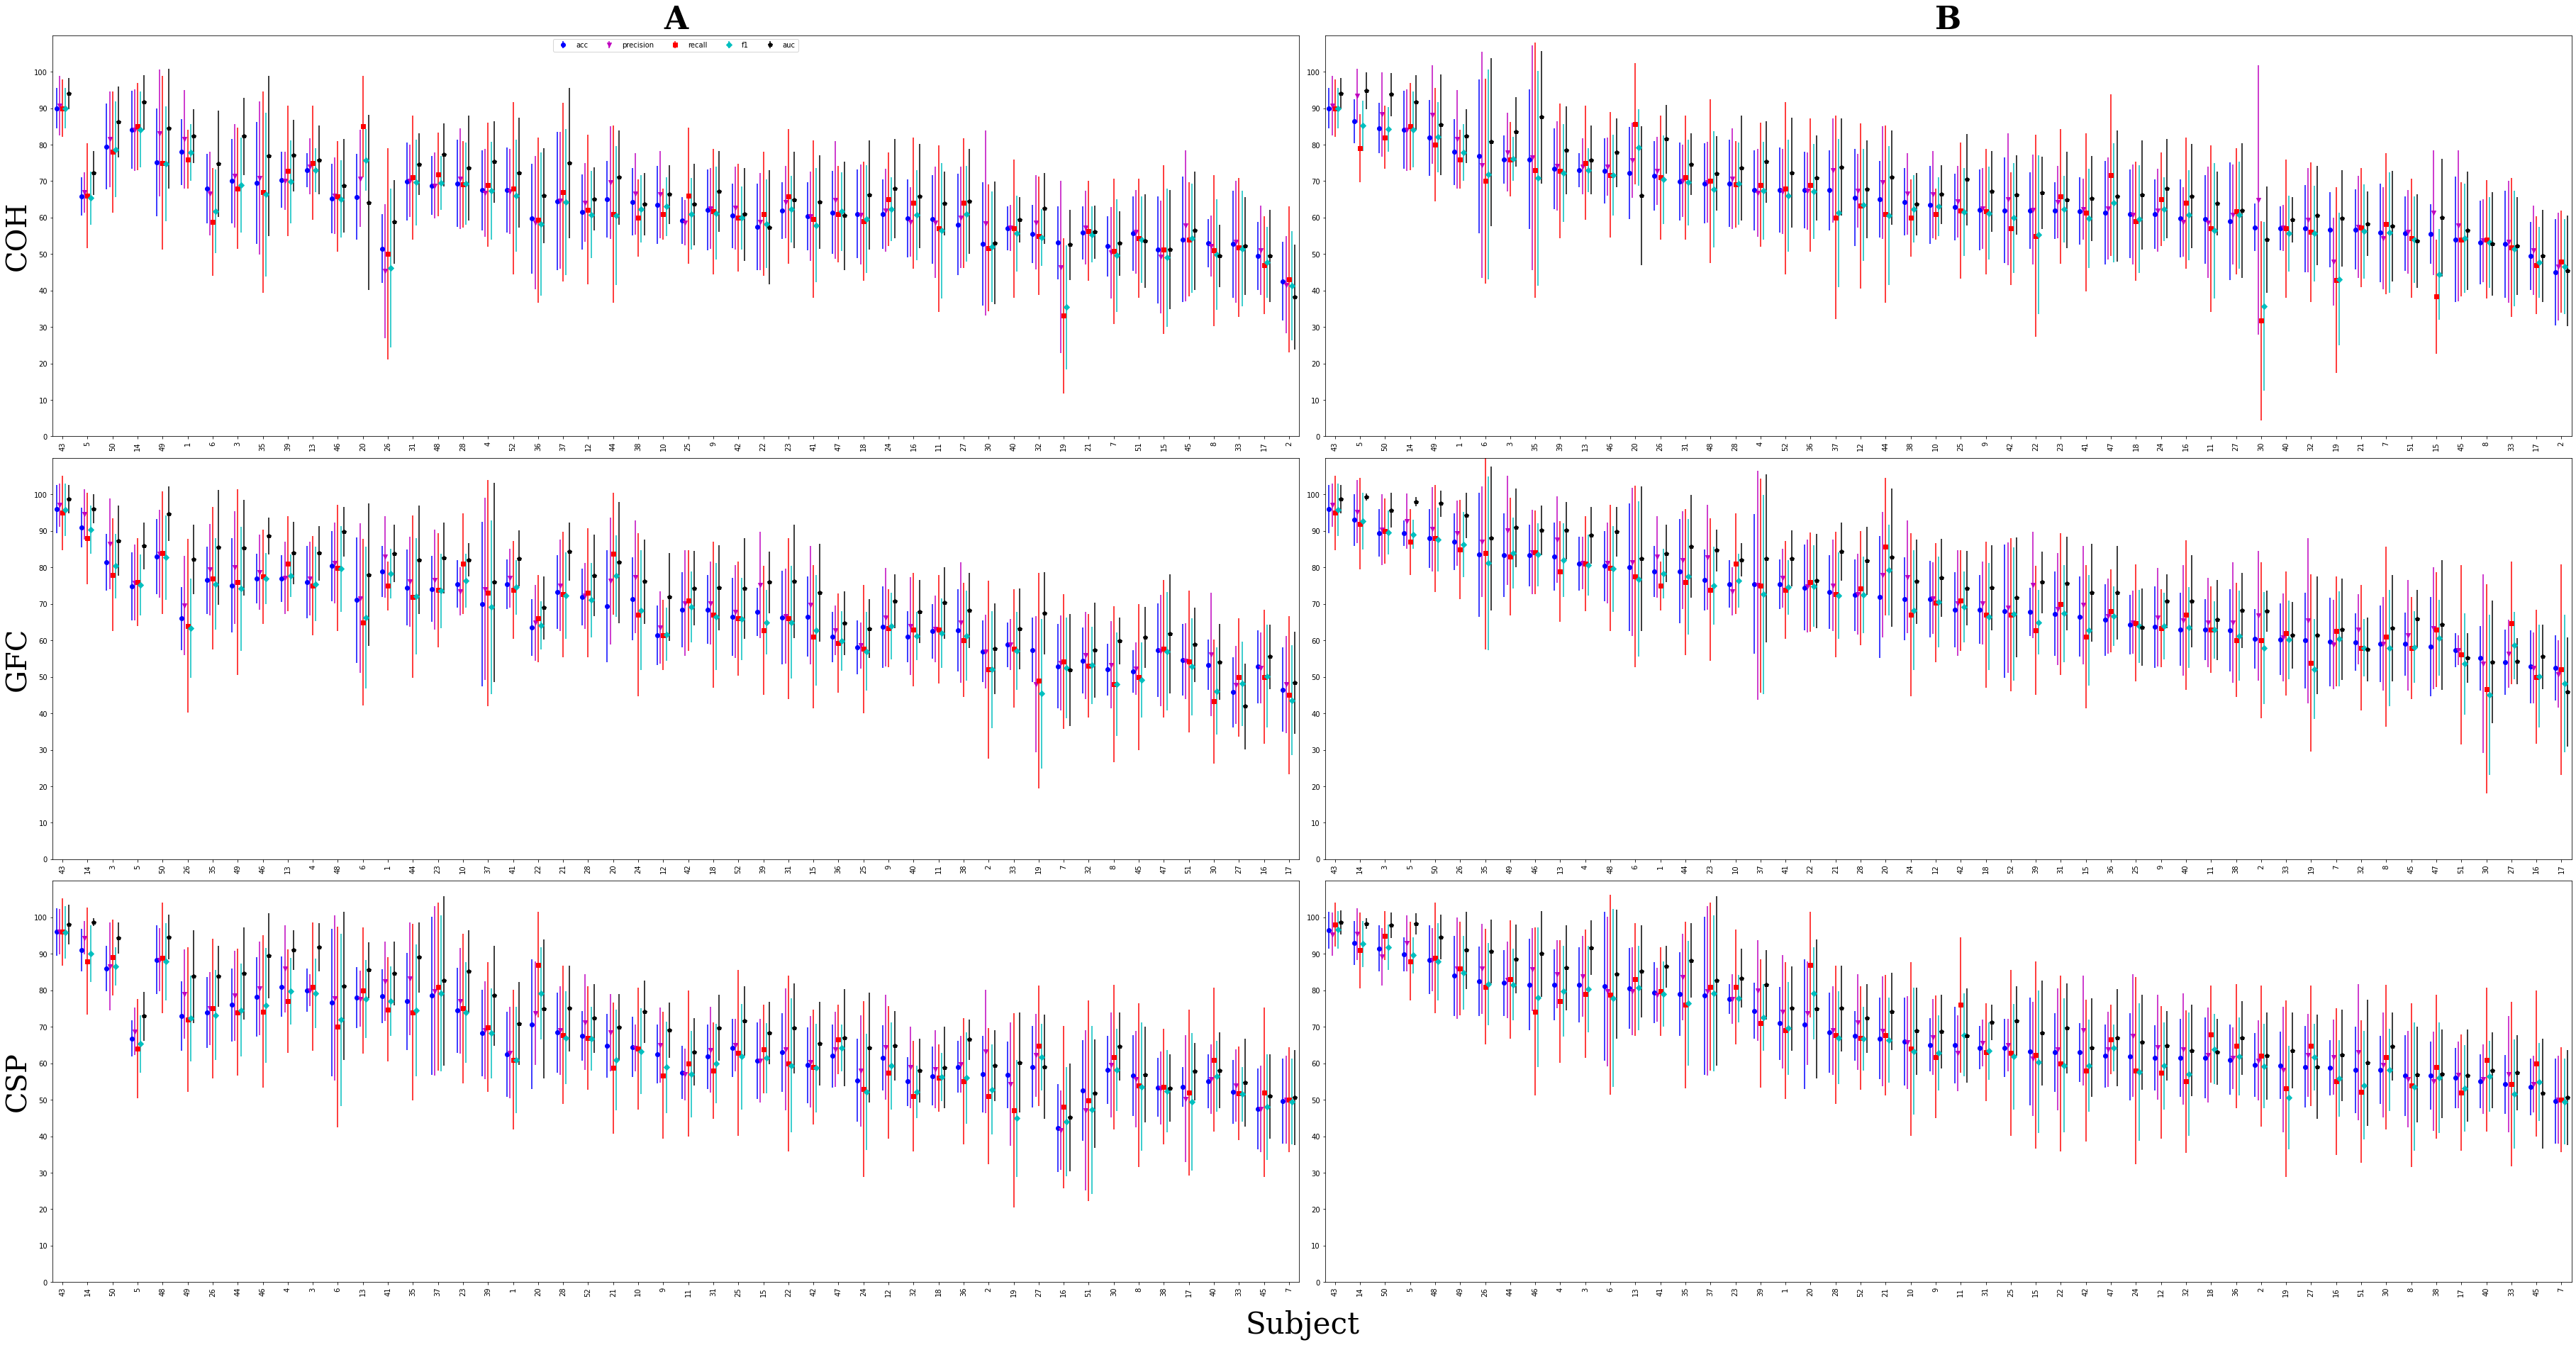

In [ ]:
evaluation_mode = ['CV/']
type_representation = ['COH', 'GFC', 'CSP']
type_preprocessing = ['No_Preprocessing', 'Preprocessing']
metrics = ['acc', 'precision', 'recall', 'f1', 'auc']
subjects = np.arange(52)+1
subjects = np.delete(subjects,[28,33])
xseed = np.array([-0.6, -0.3, 0, 0.3, 0.6])
markers = ['o', 'v', 's', 'D', 'p']
colors = ['b', 'm','r', 'c', 'k']
fig, axs = plt.subplots(len(type_representation), len(evaluation_mode)*len(type_preprocessing), figsize=(50,25), squeeze=False)

for id_eval_mode, eval_mode in zip([0,2], evaluation_mode):
  for id_type_rep, type_rep in enumerate(type_representation):
    with open(parent_dir + eval_mode  + type_rep + '.txt', 'rb') as feval:
      eval_info = load(feval) #Load CV info
    if eval_mode == 'CV/':
      sbjs_order = np.argsort(read_results(eval_info, mode=eval_mode, type_exp='Preprocessing', subjects=subjects)[0,0,:])[::-1]
    else:
      sbjs_order = np.argsort(read_results(eval_info, mode=eval_mode, type_exp='Preprocessing', subjects=subjects)[0,:])[::-1]
    for id_type_prep, type_prep in enumerate(type_preprocessing):
      sbjs_metrics = read_results(eval_info, mode=eval_mode, type_exp=type_prep, subjects=subjects)
      for id_m, m in enumerate(metrics):
        if eval_mode == 'CV/':
          axs[id_type_rep, id_type_prep+id_eval_mode].errorbar(np.arange(0, subjects.shape[0]*2.5, 2.5)+xseed[id_m], sbjs_metrics[0,id_m,sbjs_order], yerr=sbjs_metrics[1,id_m,sbjs_order], fmt=markers[id_m], color=colors[id_m], label=m)
        else:
          axs[id_type_rep, id_type_prep+id_eval_mode].stem(np.arange(0, subjects.shape[0]*2.5, 2.5)+xseed[id_m], sbjs_metrics[id_m,sbjs_order], linefmt='--'+colors[id_m], markerfmt=markers[id_m]+colors[id_m], label=m)
      if eval_mode == 'CV/':
        #axs[id_type_prep+id_eval_mode, id_type_rep].legend(loc='lower left', ncol=1)
        axs[id_type_rep, id_type_prep+id_eval_mode].set_ylim([0, 110])
      else:
        #axs[id_type_prep+id_eval_mode, id_type_rep].legend(loc='upper right', ncol=1)
        axs[id_type_rep, id_type_prep+id_eval_mode].set_ylim([0, 110])
      axs[id_type_rep, id_type_prep+id_eval_mode].set_yticks(np.arange(0, 110, 10))
      axs[id_type_rep, id_type_prep+id_eval_mode].set_xticks(np.arange(0, subjects.shape[0]*2.5, 2.5))
      axs[id_type_rep, id_type_prep+id_eval_mode].set_xlim([-1, (subjects.shape[0]-1)*2.5+1])
      axs[id_type_rep, id_type_prep+id_eval_mode].set_xticklabels(subjects[sbjs_order], rotation=90)
  axs[0, 0].legend(loc='upper center', ncol=5)
  #axs[0, 2].legend(loc='upper center', ncol=5)
fig.tight_layout()

axs[0, 0].set_ylabel('COH', fontfamily='serif', fontsize=40, weight=500)
axs[1, 0].set_ylabel('GFC', fontfamily='serif', fontsize=40, weight=500)
axs[2, 0].set_ylabel('CSP', fontfamily='serif', fontsize=40, weight=500)

axs[0, 0].set_title('A', fontfamily='serif', fontsize=44, weight=1000)
axs[0, 1].set_title('B', fontfamily='serif', fontsize=44, weight=1000)
#axs[0, 2].set_title('C', fontfamily='serif', fontsize=44, weight=1000)
#axs[0, 3].set_title('D', fontfamily='serif', fontsize=44, weight=1000)

fig.text(0.5, axs[-1,-1].get_position().y0 - 0.04, 'Subject', ha='center', fontfamily='serif', fontsize=42, weight=500)
plt.savefig(images_dir+'metrics-subjects.pdf',format='pdf', bbox_inches='tight')

#### graph 2

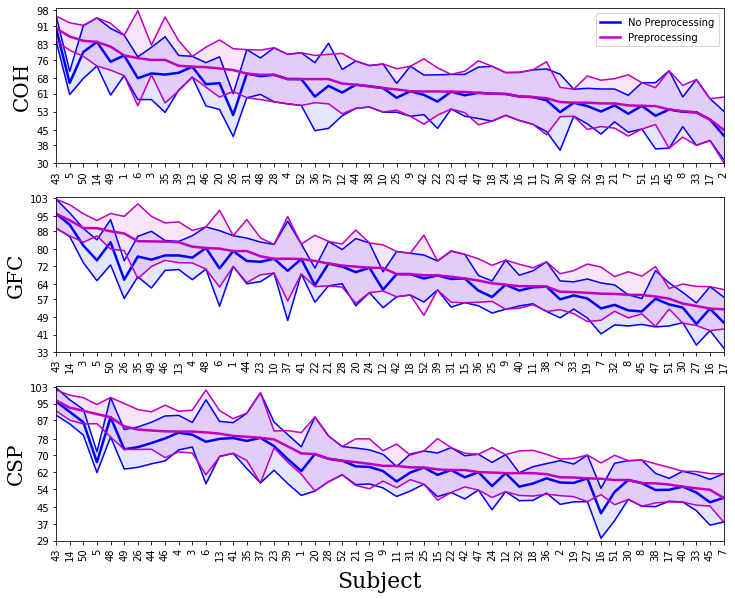

In [ ]:
type_representation = ['COH', 'GFC', 'CSP']
subjects = np.arange(52)+1
subjects = np.delete(subjects,[28,33])
fig, axs = plt.subplots(len(type_representation), figsize=(10,8))

for id_type_rep, type_rep in enumerate(type_representation):
  with open(parent_dir + 'CV/' + type_rep + '.txt', 'rb') as feval:
    eval_info = load(feval) #Load CV info
  acc_no_prep = read_results(eval_info, mode='CV/', type_exp='No_Preprocessing', subjects=subjects)
  acc_prep = read_results(eval_info, mode='CV/', type_exp='Preprocessing', subjects=subjects)
  sbjs_order = np.argsort(acc_prep[0,0,:])[::-1]
  axs[id_type_rep].fill_between(np.arange(0, subjects.shape[0]), acc_no_prep[0,0, sbjs_order]-acc_no_prep[1,0, sbjs_order], acc_no_prep[0,0, sbjs_order]+acc_no_prep[1,0, sbjs_order], color='b', alpha=0.1)
  axs[id_type_rep].plot(acc_no_prep[0,0, sbjs_order] + acc_no_prep[1,0, sbjs_order], 'b-', linewidth=1.5)
  if type_rep == 'COH':
    axs[id_type_rep].plot(acc_no_prep[0,0, sbjs_order], 'b-', linewidth=2.5, label='No Preprocessing')
  else:
    axs[id_type_rep].plot(acc_no_prep[0,0, sbjs_order], 'b-', linewidth=2.5)
  axs[id_type_rep].plot(acc_no_prep[0,0, sbjs_order] - acc_no_prep[1,0, sbjs_order], 'b-', linewidth=1.5)
  axs[id_type_rep].fill_between(np.arange(0, subjects.shape[0]), acc_prep[0,0, sbjs_order]-acc_prep[1,0, sbjs_order], acc_prep[0,0, sbjs_order]+acc_prep[1,0, sbjs_order], color='m', alpha=0.1)
  axs[id_type_rep].plot(acc_prep[0,0, sbjs_order] + acc_prep[1,0, sbjs_order], 'm-', linewidth=1.5)
  if type_rep == 'COH':
    axs[id_type_rep].plot(acc_prep[0,0, sbjs_order], 'm-', linewidth=2.5, label='Preprocessing')
  else:
    axs[id_type_rep].plot(acc_prep[0,0, sbjs_order], 'm-', linewidth=2.5)
  axs[id_type_rep].plot(acc_prep[0,0, sbjs_order] - acc_prep[1,0, sbjs_order], 'm-', linewidth=1.5)
  min_ = min(np.min(acc_no_prep[0,0, sbjs_order]-acc_no_prep[1,0, sbjs_order]), np.min(acc_prep[0,0, sbjs_order]+acc_prep[1,0, sbjs_order]))
  max_ = max(np.max(acc_no_prep[0,0, sbjs_order] + acc_no_prep[1,0, sbjs_order]), np.max(acc_prep[0,0, sbjs_order] + acc_prep[1,0, sbjs_order]))
  axs[id_type_rep].set_ylim([min_-1, max_+1])
  axs[id_type_rep].set_yticks(np.linspace(min_-1, max_+1, 10, dtype=np.int))
  axs[id_type_rep].set_xticks(np.arange(0, subjects.shape[0]))
  axs[id_type_rep].set_xlim([0, 49])
  axs[id_type_rep].set_xticklabels(subjects[sbjs_order], rotation=90)
fig.tight_layout()

axs[0].legend(loc='upper right', ncol=1)

axs[0].set_ylabel('COH', fontfamily='serif', fontsize=20, weight=500)
axs[1].set_ylabel('GFC', fontfamily='serif', fontsize=20, weight=500)
axs[2].set_ylabel('CSP', fontfamily='serif', fontsize=20, weight=500)

fig.text(0.5, axs[-1].get_position().y0 - 0.08, 'Subject', ha='center', fontfamily='serif', fontsize=22, weight=500)
plt.savefig(images_dir+'acc-subjects.pdf',format='pdf', bbox_inches='tight')

## Concatenate  CV Info 

In [ ]:
from pickle import load, dump

In [ ]:
cv_info = {}
for i in range(1,3):
  with open('./CSP_'+str(i)+'.txt', 'rb') as fcv:
    cv = load(fcv)
  cv_info.update(cv)
dump(cv_info, open('./CSP.txt', 'wb'))